# Classificador de imagens de cãos e gatos

## Introdução

Vamos classificar imagens de cães e gatos usando transferência de aprendizado de uma rede pré-treinada.

Um modelo pré-treinado é uma rede neural que foi previamente treinada em um extenso conjunto de dados, geralmente para realizar uma tarefa de classificação de imagens em grande escala.

Se um modelo for treinado em um conjunto de dados amplo e diversificado o suficiente, ele se tornará eficaz como um modelo geral do mundo visual. Podemos aproveitar os recursos aprendidos por essa rede sem precisar começar do zero ao treinar um novo modelo em um grande conjunto de dados.

Vamos seguir o seguinte fluxo neste trabalho:

- Examinar e compreender os dados.
- Criar um pipeline de entrada utilizando o Keras ImageDataGenerator.
- Construir o modelo.
- Treinar o modelo.
- Avaliar o modelo.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Pre-processamento de dados



### Download de dados

Baixa e extrai um arquivo zip contendo as imagens. Depois, cria um `tf.data.Dataset` para treinamento e validação usando o utilitário `tf.keras.utils.image_dataset_from_directory`.

In [37]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')


train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

print(PATH)

Found 2000 files belonging to 2 classes.
/root/.keras/datasets/cats_and_dogs_filtered


In [38]:
# Validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


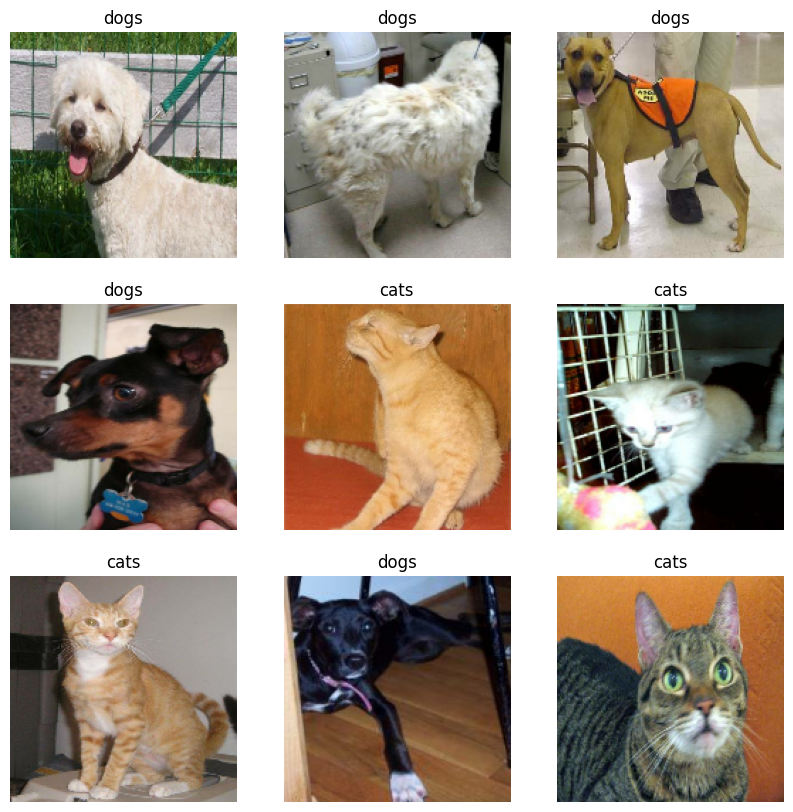

In [39]:
# Exibe as primeiras nove imagens e seus rótulos do conjunto de treinamento.
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

O conjunto de dados original não inclui um conjunto de teste, portanto, será criado um. Para isso, vamos determinar quantos lotes de dados estão disponíveis no conjunto de validação usando `tf.data.experimental.cardinality`, e usaremos 20% deles para o conjunto de teste.

In [40]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [41]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [42]:
# Configura o conjunto de dados para desempenho
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Aumentar dados

Quando não se dispõe de um grande conjunto de dados de imagens, é recomendável introduzir artificialmente outras amostras aplicando transformações aleatórias, mas realistas, às imagens de treinamento, como rotação e inversão horizontal. Isso auxilia na exposição do modelo a diferentes aspectos dos dados de treinamento e na redução do overfitting.

In [43]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Agora aplicaremos repetidamente essas camadas na mesma imagem e veremos o resultado.

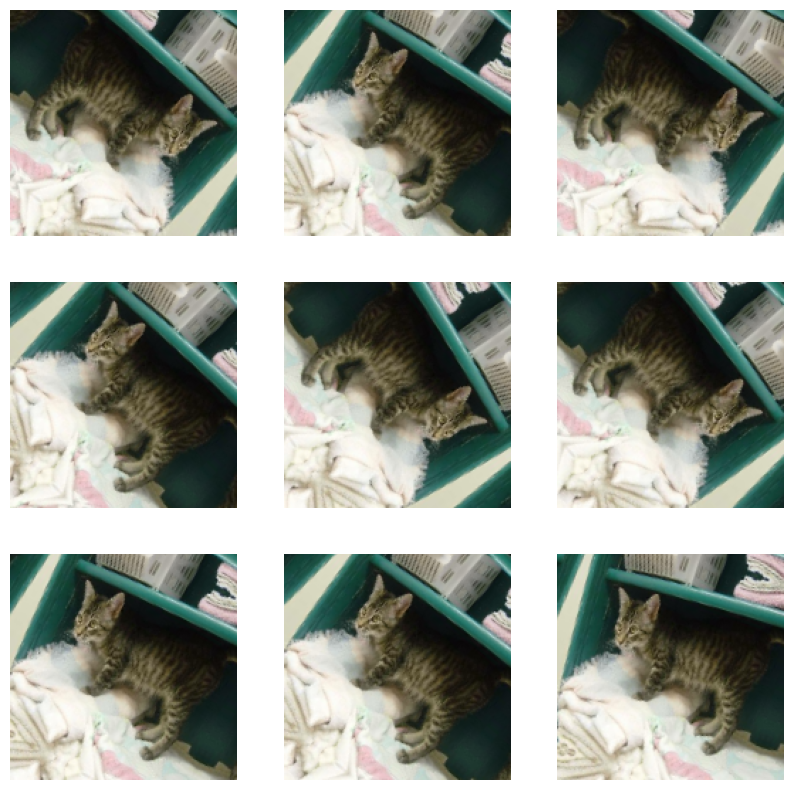

In [44]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Redimensionar valores de pixel


Faremos download do `tf.keras.applications.MobileNetV2` para uso como modelo base. Este modelo espera valores de pixel dentro do intervalo [-1, 1], porém, neste momento, os valores de pixel nas imagens estão no intervalo [0, 255]. Para redimensioná-los, utilizaremos o método de pré-processamento incluído no modelo.

In [45]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [46]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Construção do modelo base a partir de redes convolucionais pré-treinadas


O modelo base será construído utilizando o MobileNet V2 desenvolvido pelo Google. Este modelo é pré-treinado no conjunto de dados ImageNet, composto por 1,4 milhão de imagens distribuídas em 1.000 classes distintas. ImageNet  é um conjunto de dados de referência para pesquisas, abrangendo uma vasta gama de categorias, desde frutas como jaca até itens como seringas. Essa base de conhecimento será fundamental para classificar cães e gatos em nosso conjunto de dados específico.

Inicialmente, é necessário determinar qual camada do MobileNet V2 será utilizada para a extração de recursos. A última camada de classificação (localizada na "parte superior", como é comum em muitos diagramas de modelos de aprendizado de máquina, que são representados de baixo para cima) não é tão relevante para nossos propósitos. Portanto, seguiremos a prática comum de utilizar a camada imediatamente anterior à operação de achatamento. Essa camada é conhecida como "camada de gargalo". Os recursos extraídos dessa camada tendem a ser mais generalizados em comparação com a camada final/superior.

Inicialmente, vamos instanciar um modelo MobileNet V2 pré-treinado com os pesos do ImageNet. Ao especificar o argumento `include_top=False`, carregaremos uma rede que não inclui as camadas de classificação na parte superior, o que é ideal para a extração de recursos.

In [12]:
# Criar o modelo base a partir do modelo pré-treinado MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [13]:
# Este extrator de recursos converte cada imagem de 160x160x3 em um bloco de recursos de 5x5x1280.
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Extração de recursos

Nesta etapa, congelamos a base convolucional criada na etapa anterior e usamos como extrator de recursos. Além disso, adicionamos um classificador em cima dele e treinamos o classificador de nível superior.

### Congele a base convolucional

É importante congelar a base convolucional antes de compilar e treinar o modelo. O congelamento (definindo layer.trainable = False) evita que os pesos em uma determinada camada sejam atualizados durante o treinamento. O MobileNet V2 tem muitas camadas, portanto, definir o sinalizador trainable de todo o modelo como False irá congelar todas elas.

In [14]:
base_model.trainable = False

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

### Adicionar um cabeçalho de classificação


Para gerar previsões a partir do bloco de características, calcule a média das localizações espaciais 5x5, utilizando uma camada `tf.keras.layers.GlobalAveragePooling2D` para converter as características em um único vetor de 1280 elementos por imagem.

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Aplique uma camada `tf.keras.layers.Dense` para converter esses recursos em uma única previsão por imagem. Não precisa de uma função de ativação aqui porque essa previsão será tratada como um logit ou um valor bruto de previsão.
- Números positivos predizem a classe 1
- Números negativos predizem a classe 0

In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
# Constrção do modelo
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compilar o modelo

Compile o modelo antes de treiná-lo. Como existem duas classes, usamos a perda `tf.keras.losses.BinaryCrossentropy` com `from_logits=True`, pois o modelo fornece uma saída linear.

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

Os 2,5 milhões de parâmetros no MobileNet estão congelados, mas existem 1,2 mil parâmetros treináveis na camada Dense. Estes são divididos entre dois objetos `tf.Variable`, os pesos e os bias.

In [21]:
len(model.trainable_variables)

2

### Treinar o modelo

Após treinar por 10 épocas, deveremos ter ~ 94% de precisão no conjunto de validação.

In [22]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 4s 53ms/step - loss: 0.6876 - accuracy: 0.5916


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.69
initial accuracy: 0.59


In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 9s 61ms/step - loss: 0.6226 - accuracy: 0.6330 - val_loss: 0.4535 - val_accuracy: 0.7735
Epoch 2/10
63/63 [==============================] - 4s 67ms/step - loss: 0.4645 - accuracy: 0.7515 - val_loss: 0.3360 - val_accuracy: 0.8639
Epoch 3/10
63/63 [==============================] - 4s 55ms/step - loss: 0.3754 - accuracy: 0.8225 - val_loss: 0.2625 - val_accuracy: 0.9146
Epoch 4/10
63/63 [==============================] - 4s 55ms/step - loss: 0.3255 - accuracy: 0.8505 - val_loss: 0.2154 - val_accuracy: 0.9245
Epoch 5/10
63/63 [==============================] - 5s 72ms/step - loss: 0.2767 - accuracy: 0.8820 - val_loss: 0.1783 - val_accuracy: 0.9468
Epoch 6/10
63/63 [==============================] - 4s 53ms/step - loss: 0.2445 - accuracy: 0.9015 - val_loss: 0.1628 - val_accuracy: 0.9493
Epoch 7/10
63/63 [==============================] - 4s 54ms/step - loss: 0.2345 - accuracy: 0.9035 - val_loss: 0.1533 - val_accuracy: 0.9505
Epoch 8/10
63

### Curvas de aprendizado

Curvas de aprendizado da precisão/perda de treinamento e validação ao usar o modelo base MobileNetV2 como um extrator de recursos fixo.

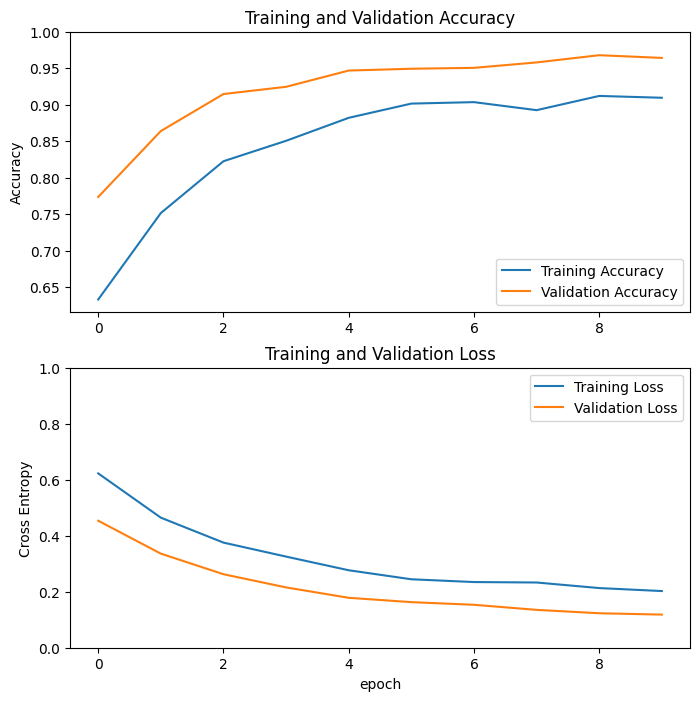

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Ajustes

No experimento de extração de recursos, treinamos apenas algumas camadas em cima de um modelo base MobileNetV2. Os pesos da rede pré-treinada não foram atualizados durante o treinamento.

Uma maneira de aumentar ainda mais o desempenho é treinar (ou "ajustar") os pesos das camadas superiores do modelo pré-treinado juntamente com o treinamento do classificador que você adicionou. O processo de treinamento forçará os pesos a serem ajustados de mapas de recursos genéricos para recursos associados especificamente ao conjunto de dados.

Além disso, tentaremos ajustar um pequeno número de camadas superiores em vez de todo o modelo MobileNet. Na maioria das redes convolucionais, quanto mais alta uma camada, mais especializada ela é. As primeiras camadas aprendem recursos muito simples e genéricos que se generalizam para quase todos os tipos de imagens. À medida que subimos nas camadas, os recursos são cada vez mais específicos para o conjunto de dados no qual o modelo foi treinado. O objetivo do ajuste fino é adaptar esses recursos especializados para trabalhar com o novo conjunto de dados, em vez de substituir o aprendizado genérico.

Para isso vamos descongelar o base_model e definir as camadas inferiores como não treináveis. Em seguida, recompilaremos o modelo (necessário para que essas alterações tenham efeito) e retomaremos o treinamento.

In [26]:
base_model.trainable = True

In [27]:
# Verifica quantas camadas existem no modelo base
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

# Congela todas as camadas antes da camada fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [30]:
len(model.trainable_variables)

56

Esta etapa melhorará a precisão do modelo.

In [31]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 15s 96ms/step - loss: 0.1586 - accuracy: 0.9390 - val_loss: 0.0586 - val_accuracy: 0.9802
Epoch 11/20
63/63 [==============================] - 5s 72ms/step - loss: 0.1269 - accuracy: 0.9450 - val_loss: 0.0682 - val_accuracy: 0.9740
Epoch 12/20
63/63 [==============================] - 4s 58ms/step - loss: 0.1093 - accuracy: 0.9555 - val_loss: 0.0465 - val_accuracy: 0.9827
Epoch 13/20
63/63 [==============================] - 4s 60ms/step - loss: 0.0897 - accuracy: 0.9650 - val_loss: 0.0621 - val_accuracy: 0.9839
Epoch 14/20
63/63 [==============================] - 5s 73ms/step - loss: 0.0851 - accuracy: 0.9625 - val_loss: 0.0507 - val_accuracy: 0.9814
Epoch 15/20
63/63 [==============================] - 4s 59ms/step - loss: 0.0737 - accuracy: 0.9745 - val_loss: 0.0343 - val_accuracy: 0.9864
Epoch 16/20
63/63 [==============================] - 4s 61ms/step - loss: 0.0706 - accuracy: 0.9700 - val_loss: 0.0388 - val_accuracy: 0.9889
Epoch

Curvas de aprendizado da precisão/perda de treinamento e validação ao ajustar as últimas camadas do modelo base do MobileNetV2 e treinar o classificador em cima dele.  

A perda de validação é muito maior do que a perda de treinamento, então pode ter algum overfitting. Também pode ter overfitting devido ao novo conjunto de treinamento ser relativamente pequeno e semelhante aos conjuntos de dados originais do MobileNetV2.

Após o ajuste fino, o modelo atinge quase 98% de precisão no conjunto de validação.

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

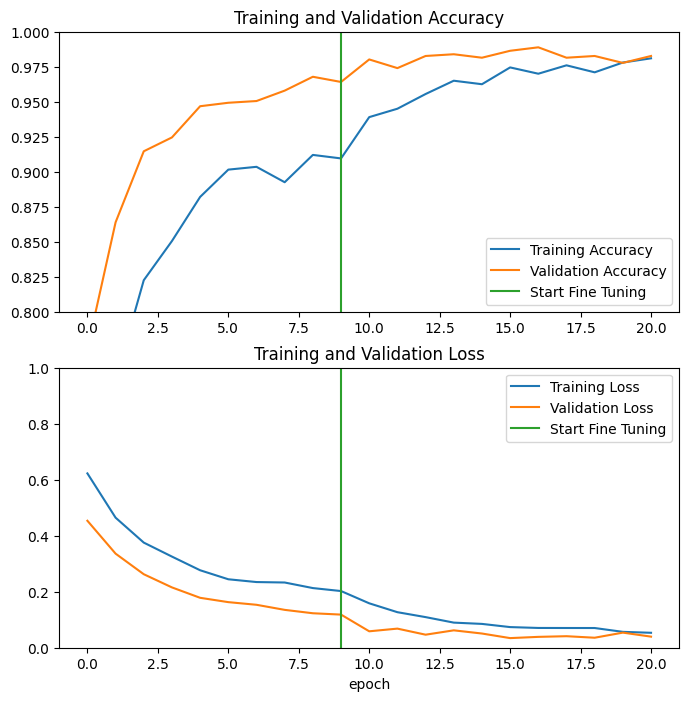

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Avaliação e previsão

Finalmente, poderemos verificar o desempenho do modelo em novos dados usando o conjunto de teste.

In [34]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 41ms/step - loss: 0.0460 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


 Usamos esse modelo para prever se seu animal de estimação é um gato ou um cachorro.

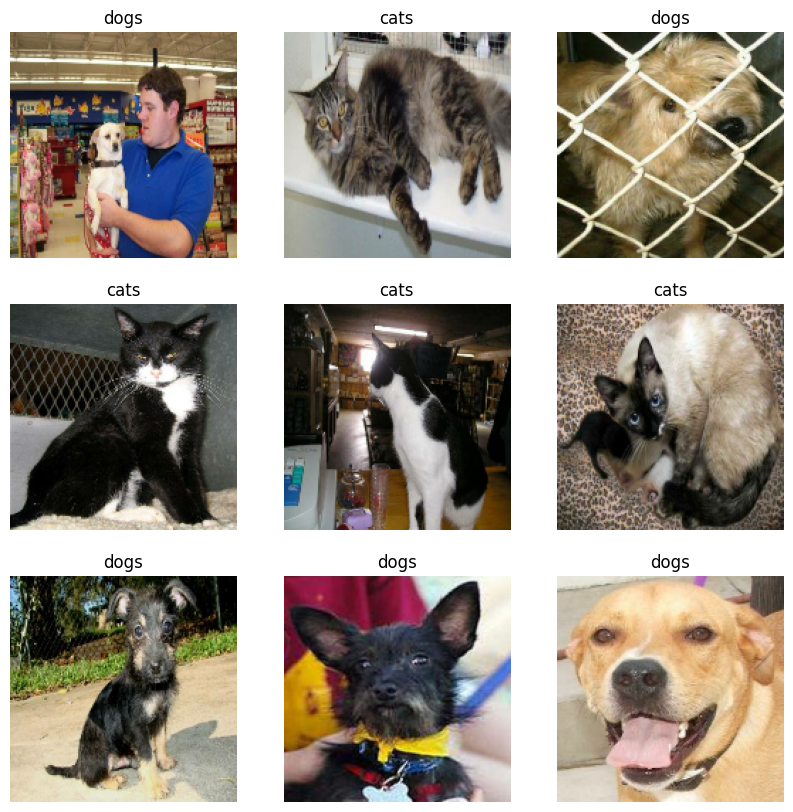

In [36]:
# Recupera um lote de imagens do conjunto de teste
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Aplica uma função sigmoid
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Resumo


**Usar um modelo pré-treinado para extração de recursos**: Ao lidar com um conjunto de dados pequeno, é comum aproveitar os recursos aprendidos por um modelo treinado em um conjunto de dados maior do mesmo domínio. Isso é feito instanciando o modelo pré-treinado e adicionando um classificador totalmente conectado no topo. O modelo pré-treinado é "congelado", e apenas os pesos do classificador são atualizados durante o treinamento. Nesse caso, a base convolucional extraiu todos os recursos associados a cada imagem, treinou um classificador que determina a classe da imagem a partir desse conjunto de recursos extraídos.

**Ajustando um modelo pré-treinado**: Para melhorar ainda mais o desempenho, pode-se desejar redirecionar as camadas de nível superior dos modelos pré-treinados para o novo conjunto de dados por meio de ajuste fino. Nesse caso, ajustou-se os pesos para que o modelo aprendesse recursos de alto nível específicos para o conjunto de dados. Essa técnica geralmente é recomendada quando o conjunto de dados de treinamento é grande e muito semelhante ao conjunto de dados original no qual o modelo pré-treinado foi treinado.